Read the CSV file created by the CCU Historian, ensure that field separator is ';' and decimal separator is '.', if necessary edit CSV file before reading it by the provided script 'csv_convert_historian.bsh'<br/>
The provided script 'get_new_history.bsh' is search for the CCU Historian's CSV in the directory '${HOME}/Downloads'. The conversion script 'csv_convert_historian.bsh' is invoked inside 'csv_convert_historian.bsh'<br/>


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime

import numpy as np


dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
  
df = pd.read_csv("historian.csv", sep=';', decimal=".", skiprows = [0,1,2],dtype={'High': np.float64, 'Low': np.float64}, header = None, encoding= 'unicode_escape',  parse_dates=[0], date_parser=dateparse, names = [ 'Datum', 'Mode', 'raw_gas_resistance', 'relative_humidity', 'temperature'])

df['raw_gas_resistance'] *= 1000.0
#df.shape
#df.columns
#df.dtypes

df.head()
#df['Datum']
#type(df['sensor 1'][0])

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-11-30 18:50:03.616,2,57260.0,36,21.1
1,2020-11-30 18:53:32.447,2,57260.0,36,21.1
2,2020-11-30 18:53:32.458,2,57260.0,36,21.1
3,2020-11-30 18:53:32.464,2,57380.0,36,21.1
4,2020-11-30 18:57:57.792,2,57380.0,36,21.2


Time series diagram of the measured raw gas resistance

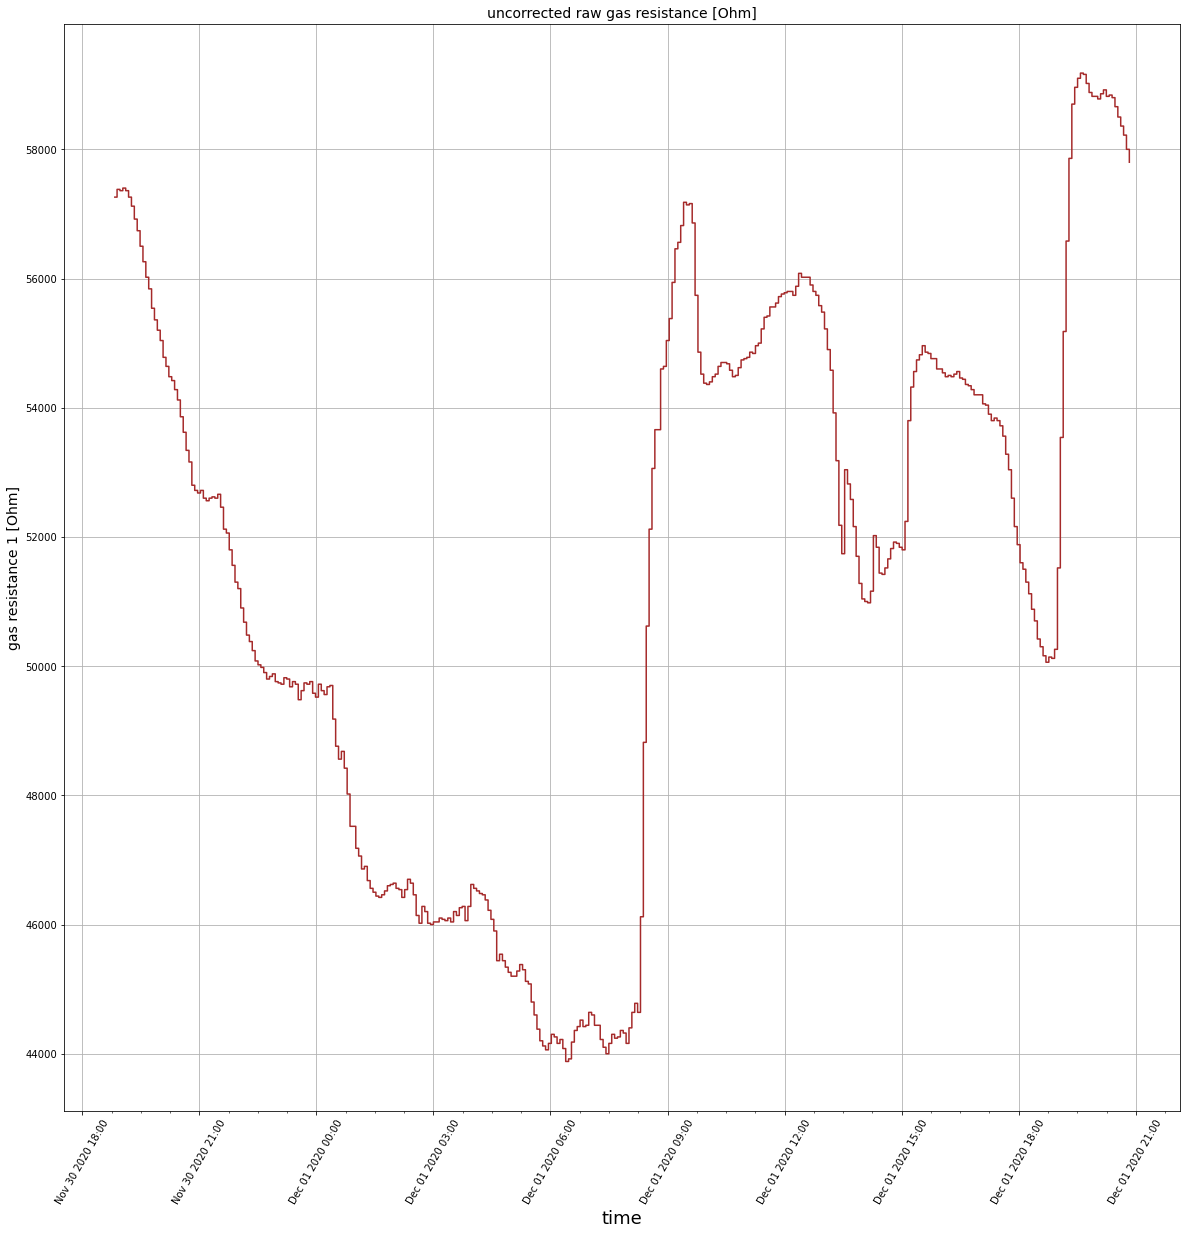

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.plot_date(df['Datum'], df['raw_gas_resistance'], linestyle='solid', marker=" ", color='brown')         
plt.title('uncorrected raw gas resistance [Ohm]', fontsize=14)
plt.xlabel('time', fontsize=18)
plt.ylabel('gas resistance 1 [Ohm]', fontsize=14)
plt.grid(True)
plt.show()

Time series diagram of the measured temperature 

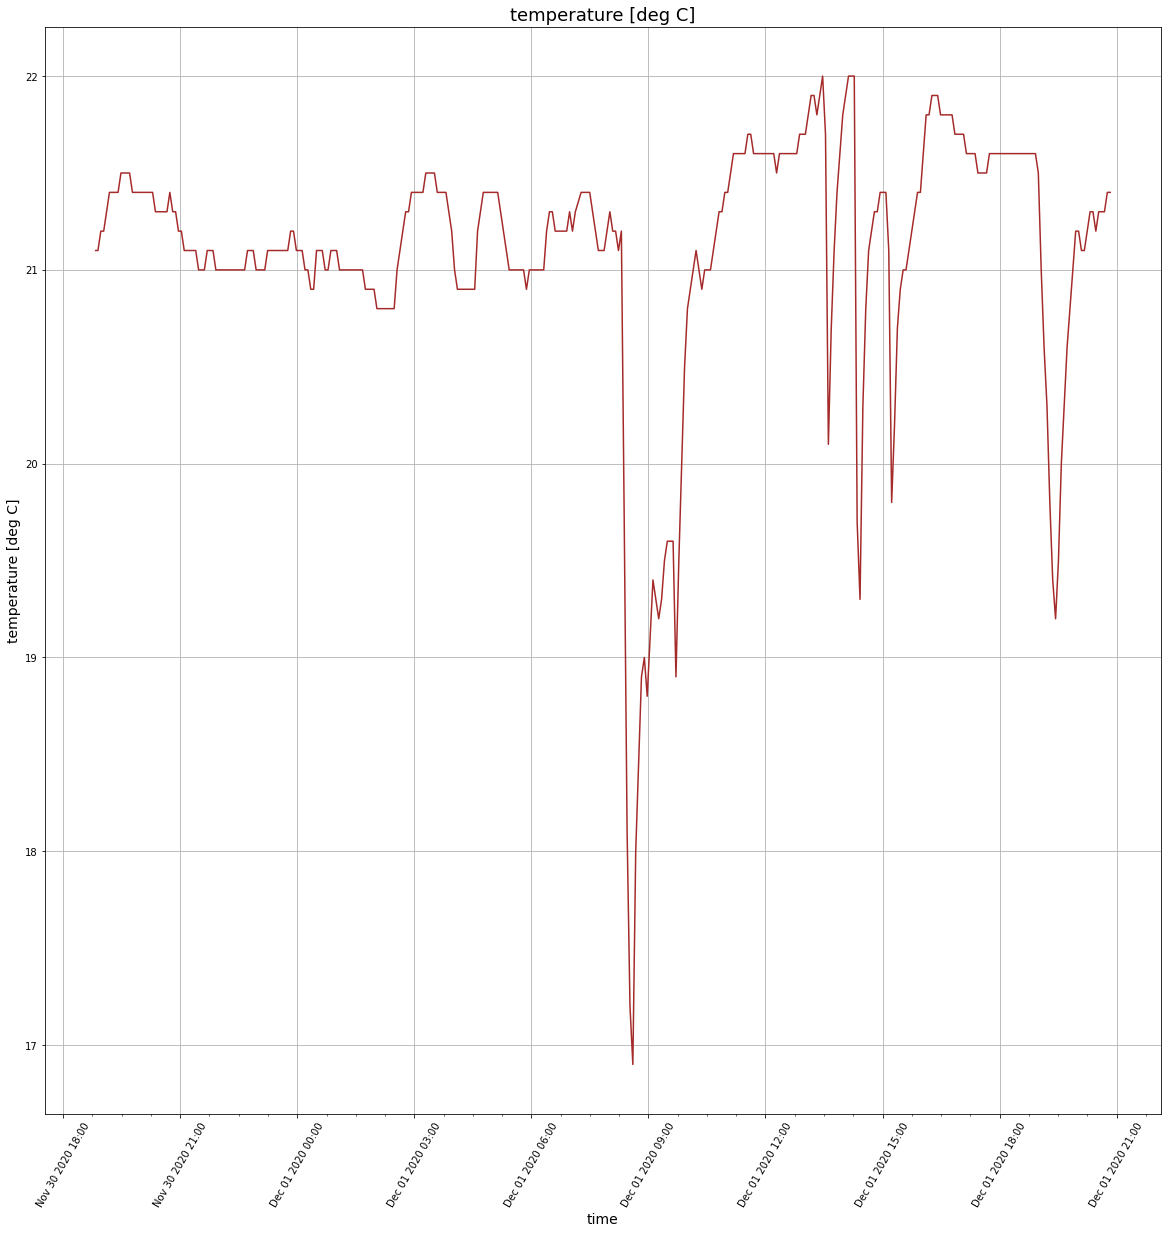

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.plot_date(df['Datum'], df['temperature'], linestyle='solid', marker=" ", color='brown')         
plt.title('temperature [deg C]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('temperature [deg C]', fontsize=14)
plt.grid(True)
plt.show()

Time series diagram of the measured relative humidity 

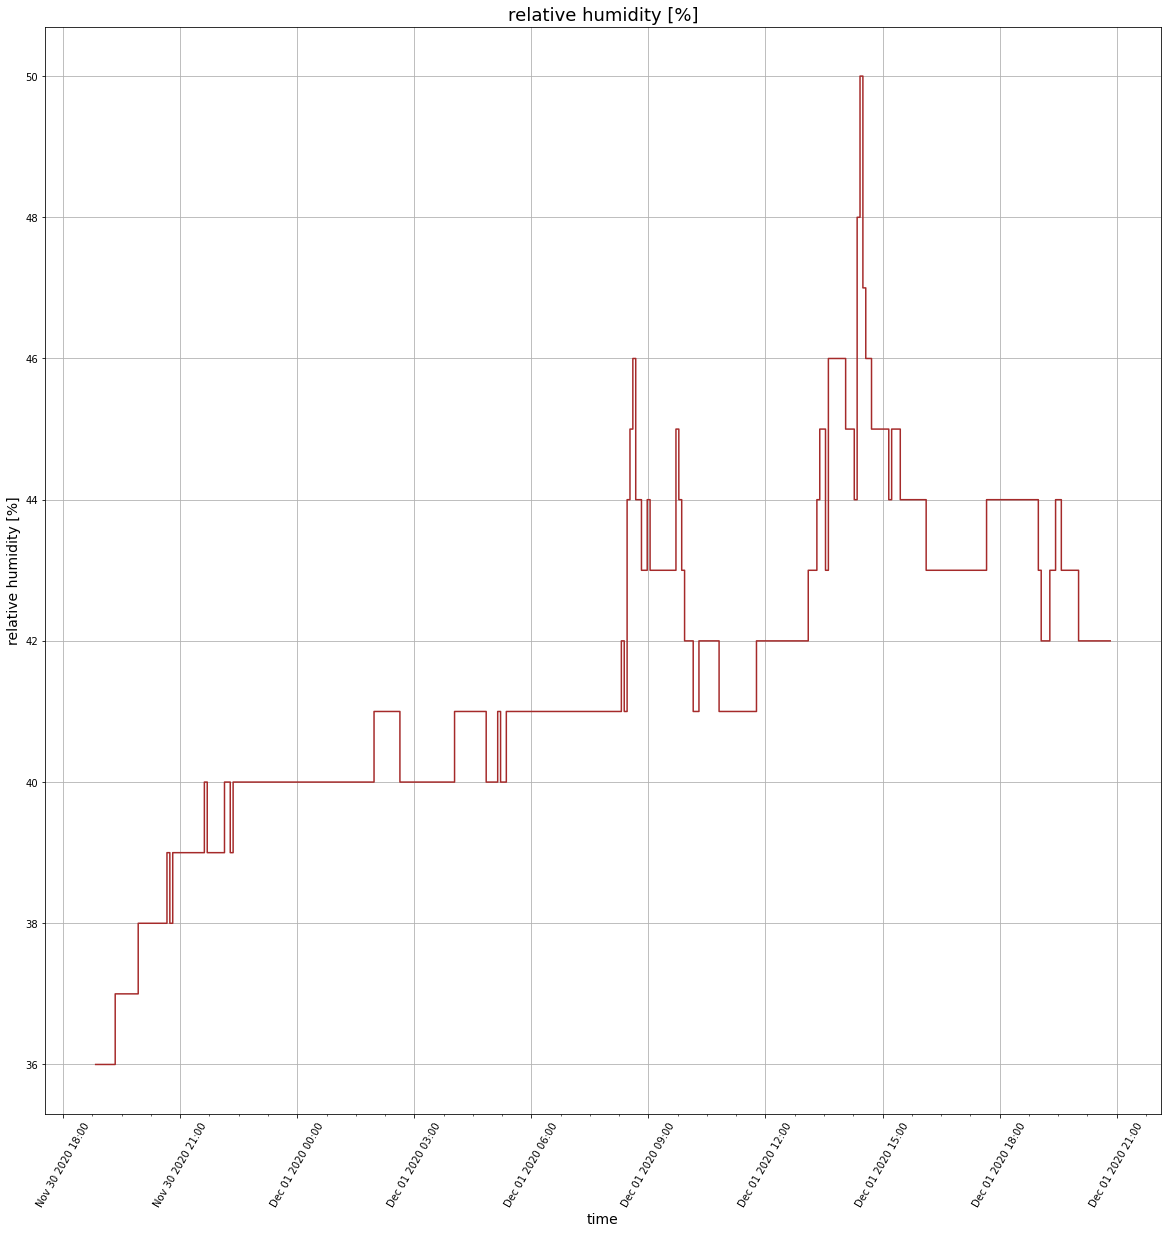

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.plot_date(df['Datum'], df['relative_humidity'], linestyle='solid', marker=" ", color='brown')         
plt.title('relative humidity [%]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('relative humidity [%]', fontsize=14)
plt.grid(True)
plt.show()

Calculate and plot the absolute humidity from temperature and relative humidity by an approximate formuala (same formula as used inside the sensor)

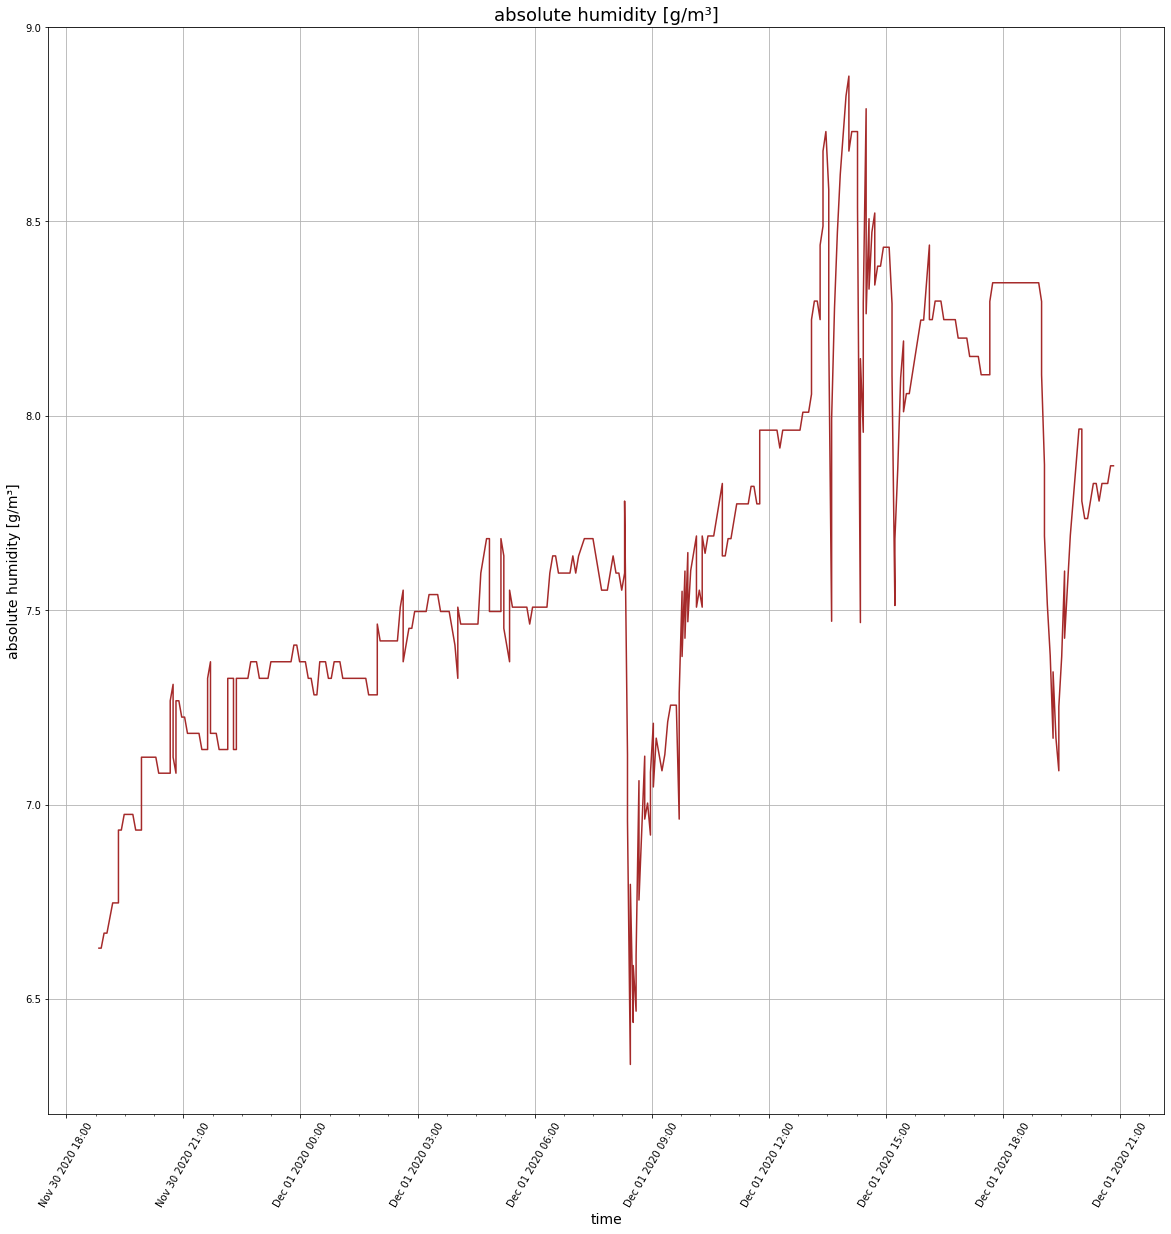

In [5]:
import numpy as np
# Create a function that  calculates the absolute humidity from the two arguments 'temperature' and 'relative humidity'
# see for details https://www.kompf.de/weather/vent.html or  https://rechneronline.de/barometer/luftfeuchtigkeit.php for x-checking the calculated result

a = 6.112
b = 17.67
c = 243.5

# Compute saturated water vapor pressure in hPa
# Param t - temperature in °C
def svp(t):
  svp = a * np.exp((b*t)/(c+t))
  return svp

# Compute actual water vapor pressure in hPa
# Param rh - relative humidity in %
# Param t - temperature in °C
def vp(rh, t):
  vp = rh/100. * svp(t)
  return vp

# Compute the absolute humidity in g/m³
# Param rh - relative humidity in %
# Param t - temperature in °C
def calculate_absolute_humidity(t, rh):
  mw = 18.016 # kg/kmol (Molekulargewicht des Wasserdampfes)
  rs = 8314.3 # J/(kmol*K) (universelle Gaskonstante)
  ah = 10**5 * mw/rs * vp(rh, t)/(t + 273.15)
  #return the absolute humidity in [g/m³]
  return ah

# now apply the above defined formulas to get the pandas dataframe column 'absolute_humidity'
df['absolute_humidity'] = calculate_absolute_humidity(df['temperature'], df['relative_humidity'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.plot_date(df['Datum'], df['absolute_humidity'], linestyle='solid', marker=" ", color='brown')         
plt.title('absolute humidity [g/m³]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('absolute humidity [g/m³]', fontsize=14)
plt.grid(True)
plt.show()



Scatter plot of raw gas resistance versus the absolute humidityy, is the dependency somehow linear (should be for a multilinear regression)?

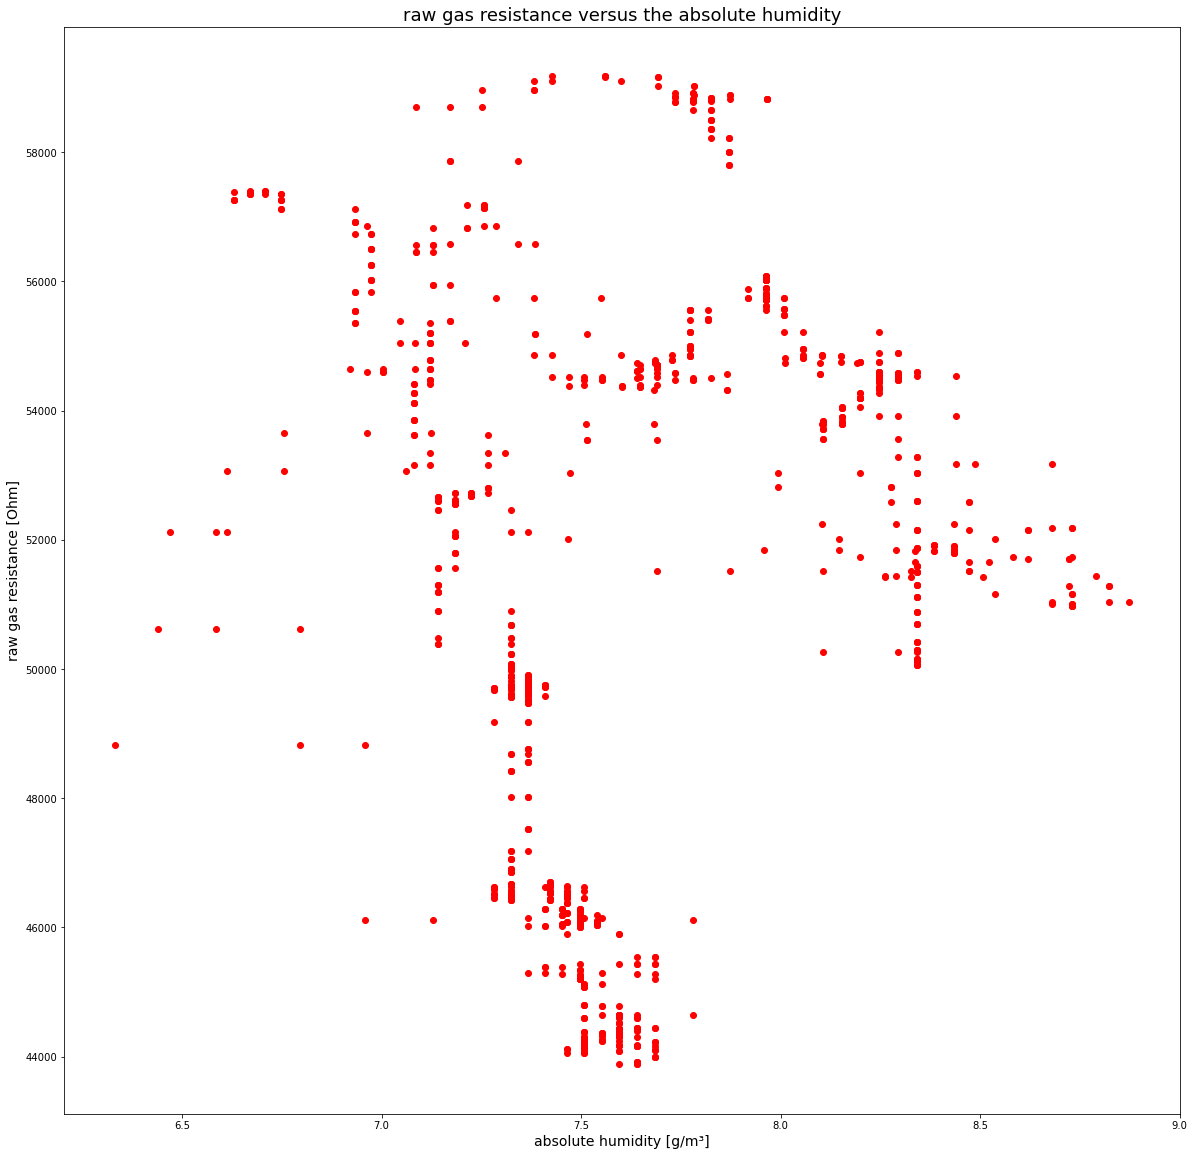

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(20,20))

plt.scatter(df['absolute_humidity'], df['raw_gas_resistance'], color='red')
plt.title('raw gas resistance versus the absolute humidity', fontsize=18)
plt.xlabel('absolute humidity [g/m³]', fontsize=14)
plt.ylabel('raw gas resistance [Ohm]', fontsize=14)
plt.show()

Scatter plot of raw gas resistance versus the temperature, is the dependency somehow linear (should be for a multilinear regression)?

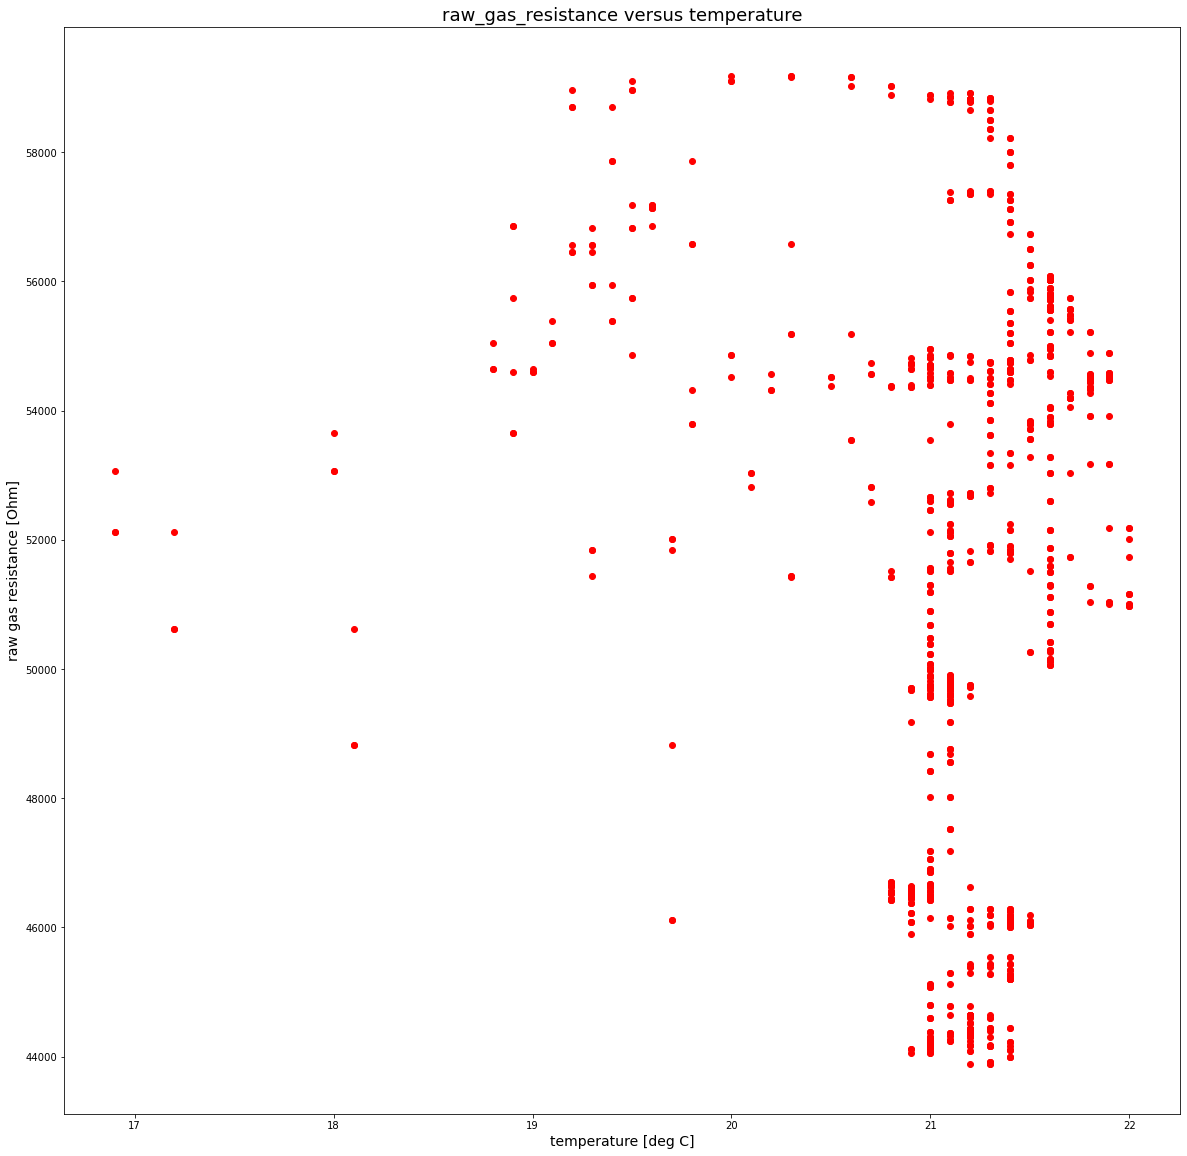

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(20,20))
plt.scatter(df['temperature'], df['raw_gas_resistance'], color='red')
plt.title('raw_gas_resistance versus temperature', fontsize=18)
plt.xlabel('temperature [deg C]', fontsize=14)
plt.ylabel('raw gas resistance [Ohm]', fontsize=14)
plt.grid(False)
plt.show()

Execute a multiple linear regression of raw gas resistance oin dependency of the absolute humidity and the temperature<br/>
use the prediction 'predictions1' of the mutiple linear regression to create a corrected gas resistance 'residuals' with eliminated influence of the absolute humidity and the temperature<br/>
create a normalized scaled corrected gas resistance 'normalized_residuals'

Intercept: 
 60330.60683045938
Coefficients: 
 [-1105.77464689  1879.61098284]
                                 OLS Regression Results                                
Dep. Variable:     raw_gas_resistance   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          6.099e+04
Date:                Sun, 06 Dec 2020   Prob (F-statistic):                        0.00
Time:                        19:12:04   Log-Likelihood:                         -10339.
No. Observations:                1046   AIC:                                  2.068e+04
Df Residuals:                    1044   BIC:                                  2.069e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

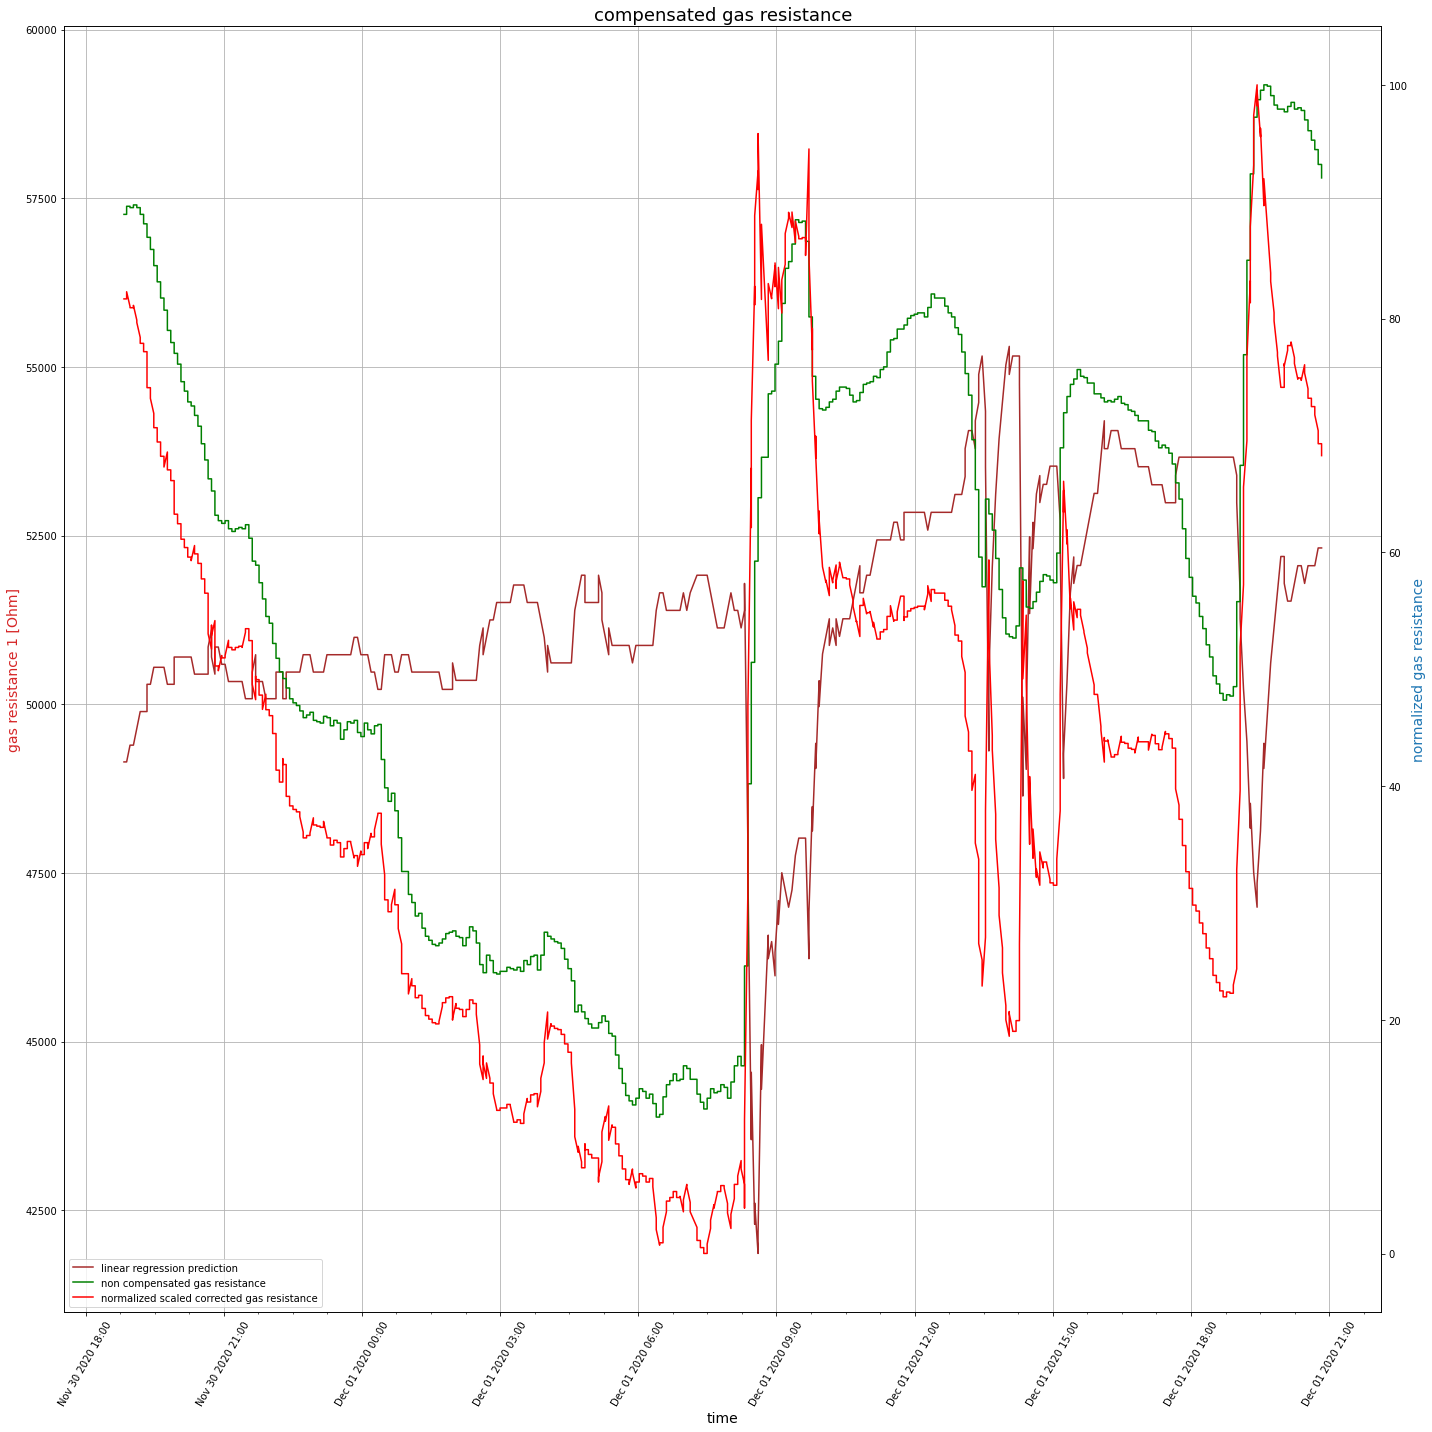

In [8]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


X = df[['temperature','absolute_humidity']] # here we have 2 variables for multiple regression
Y = df['raw_gas_resistance']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)
print(model.rsquared)

residuals=df['raw_gas_resistance']-predictions
min_res=min(residuals)
max_res=max(residuals)

#clip min of residual to epsilon in order to avoid a log(0) trap
epsilon=0.0001

normalized_residuals=((residuals-min_res)/(max_res-min_res)).clip(epsilon,None)*100


fig, ax1 = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax1.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax1.xaxis.set_minor_locator(AutoMinorLocator())

lns1=ax1.plot_date(df['Datum'], predictions, linestyle='solid', marker=" ", color='brown', label='linear regression prediction')
lns2=ax1.plot_date(df['Datum'], df['raw_gas_resistance'], linestyle='solid', marker=" ", color='green', label='non compensated gas resistance')
color = 'tab:red'
ax1.set_xlabel('time', fontsize=14)
ax1.set_ylabel('gas resistance 1 [Ohm]', color=color, fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax2.xaxis.set_minor_locator(AutoMinorLocator())

color = 'tab:blue'
ax2.set_ylabel('normalized gas resistance', color=color, fontsize=14)  # we already handled the x-label with ax1
lns3=ax2.plot_date(df['Datum'], normalized_residuals, linestyle='solid', marker=" ", color='red', label='normalized scaled corrected gas resistance')

plt.title('compensated gas resistance', fontsize=18)

ax1.grid(True)
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


time series diagrams of normalized scaled gas resistance; y range is 0.0..100.0 [%]

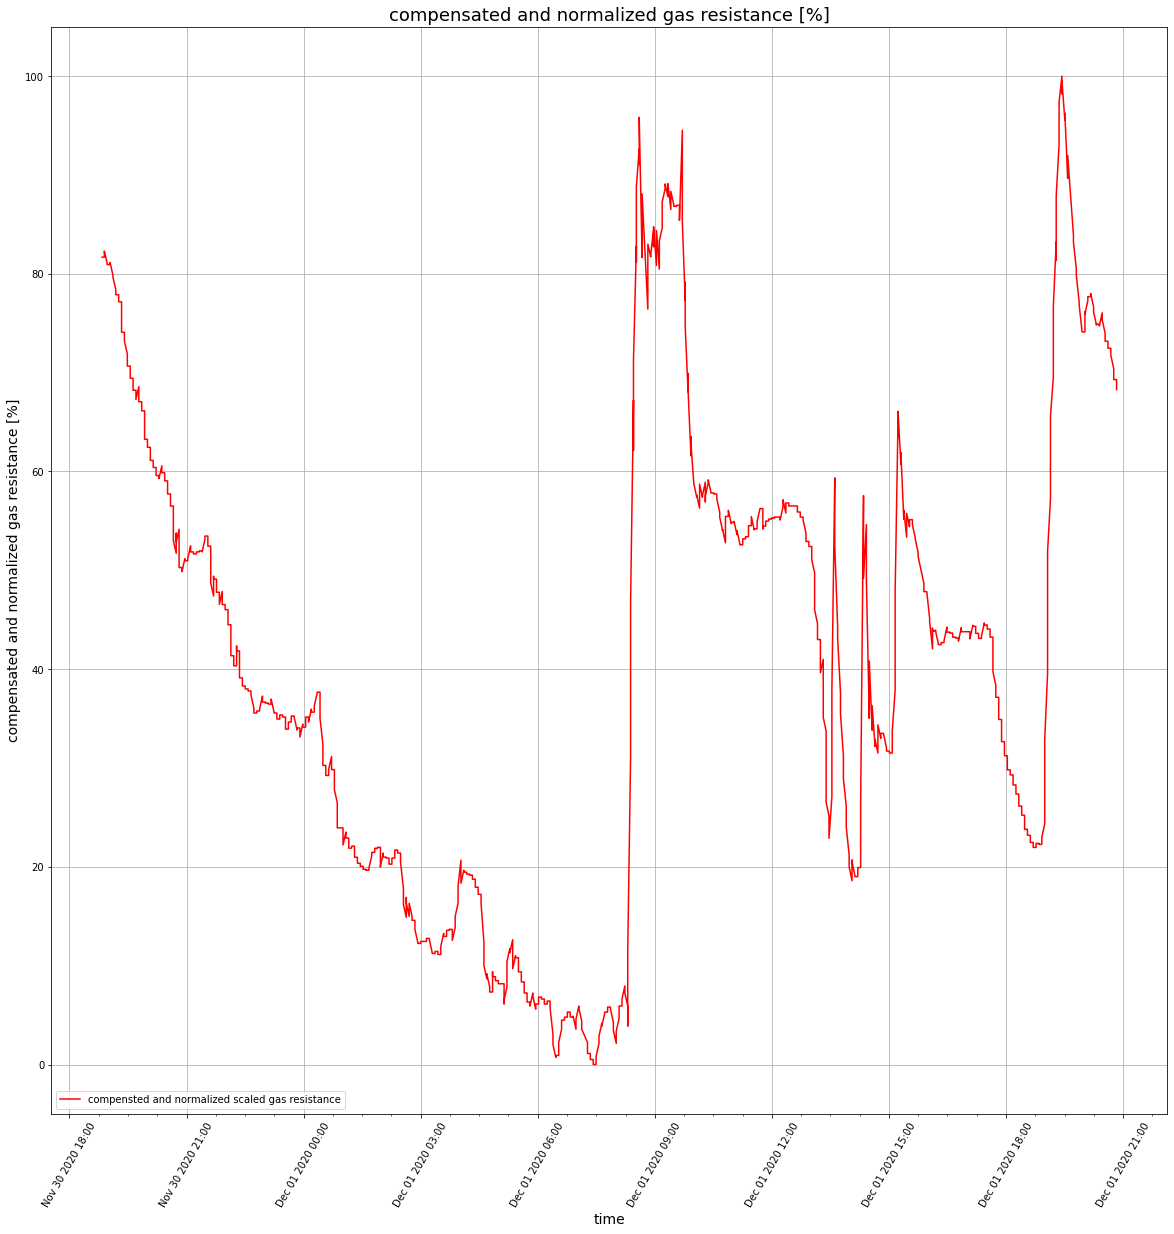

In [9]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.plot_date(df['Datum'], normalized_residuals, linestyle='solid', marker=" ", color='red', label='compensted and normalized scaled gas resistance')

plt.title('compensated and normalized gas resistance [%]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('compensated and normalized gas resistance [%]', fontsize=14)
plt.grid(True)
plt.legend(loc ="lower left")
plt.show()

time series diagrams of compensated and normalized scaled gas resistance with logarithmic y scale 0.01 .. 100

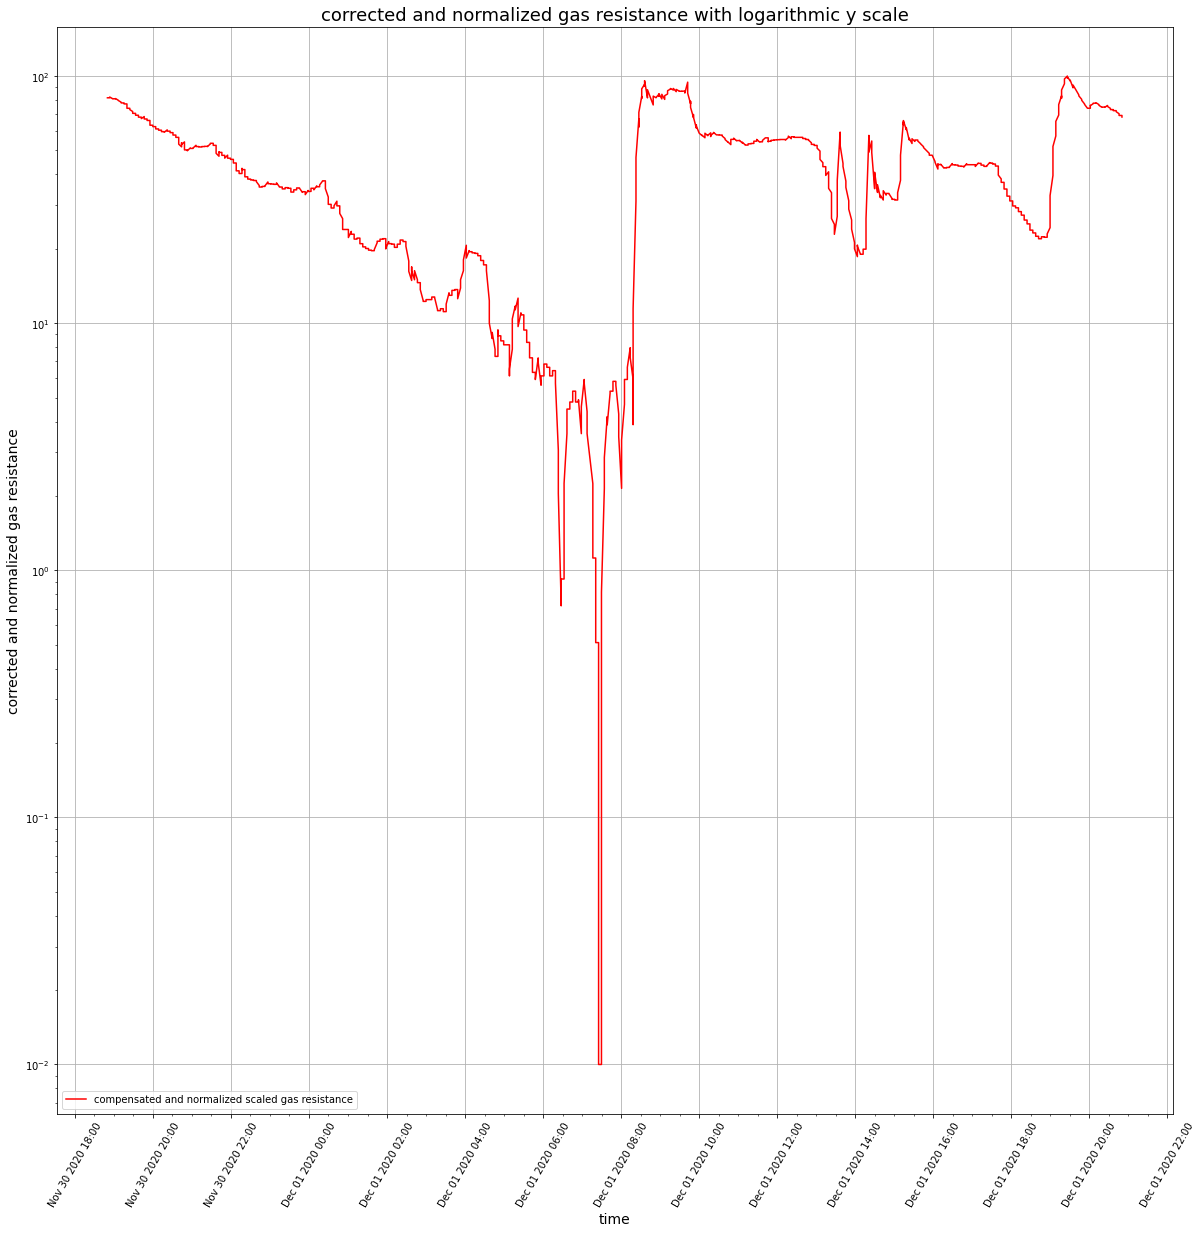

In [10]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


fig, ax = plt.subplots(figsize=(20, 20))
plt.yscale('log')
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))
hours = mdates.HourLocator(interval = 2)  
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_minor_locator(AutoMinorLocator())


plt.xticks(rotation=60)
plt.plot_date(df['Datum'], normalized_residuals, linestyle='solid', marker=" ", color='red', label='compensated and normalized scaled gas resistance')

plt.title('corrected and normalized gas resistance with logarithmic y scale', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('corrected and normalized gas resistance', fontsize=14)
plt.grid(True)
plt.legend(loc ="lower left")
plt.show()

time series diagrams of the logarithmic air quality level
the air quality level can vary between 0.0 (fresh air) and 4.0 (very poor air quality)

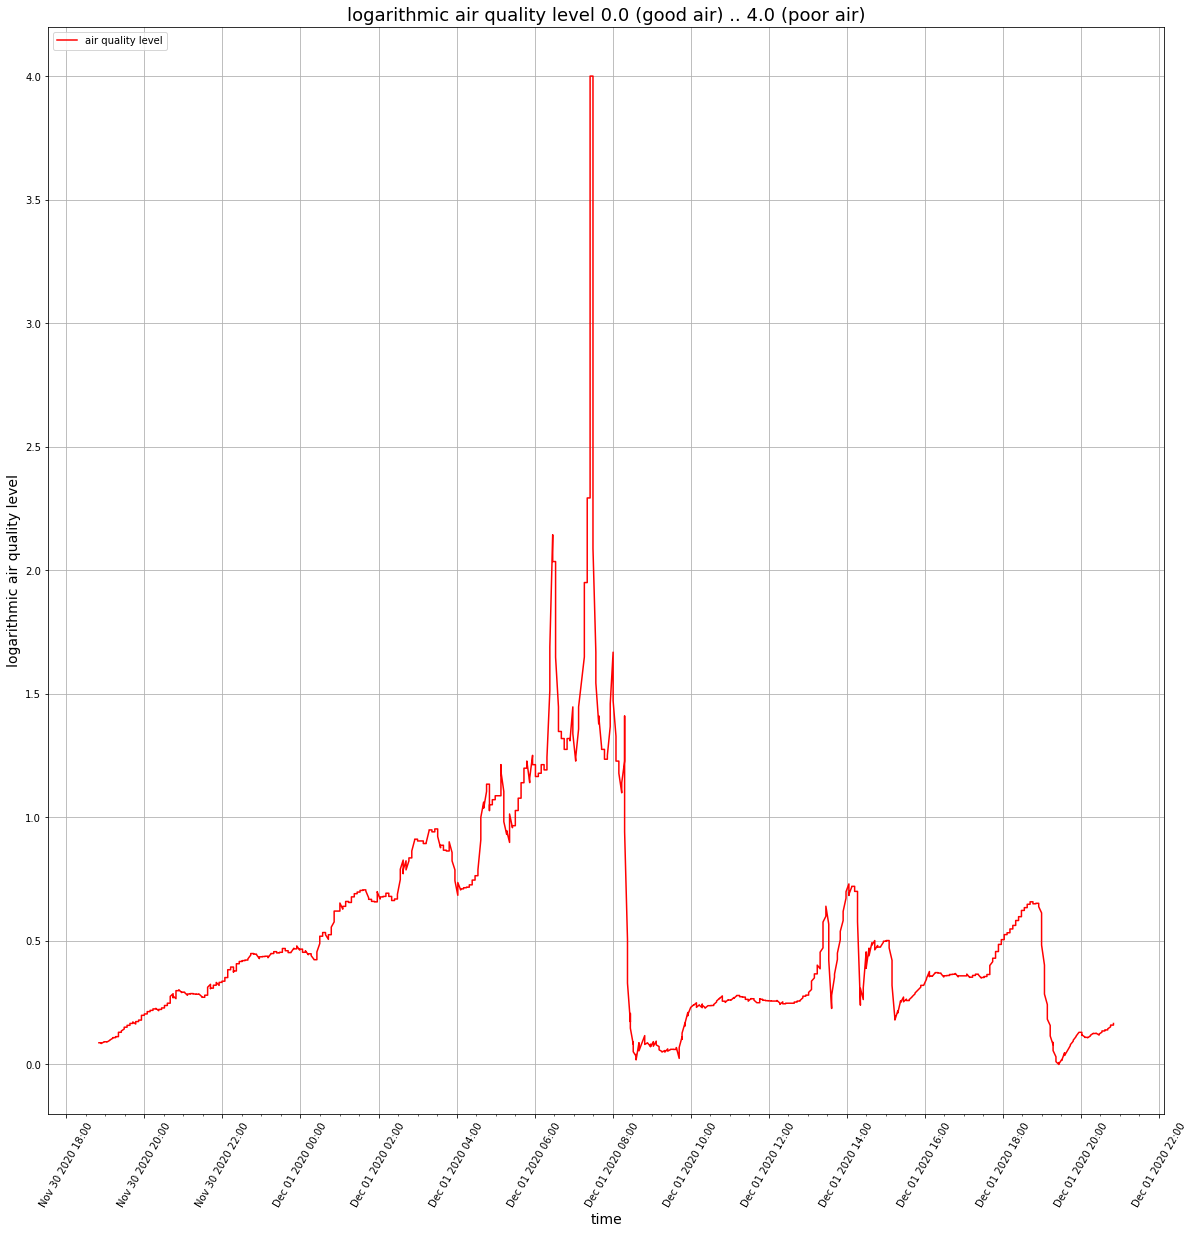

In [11]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

log_normalized_residuals = -(np.log10(normalized_residuals)-2)


fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))
hours = mdates.HourLocator(interval = 2)  
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_minor_locator(AutoMinorLocator())


plt.xticks(rotation=60)
plt.plot_date(df['Datum'], log_normalized_residuals, linestyle='solid', marker=" ", color='red', label='air quality level')

plt.title('logarithmic air quality level 0.0 (good air) .. 4.0 (poor air)', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('logarithmic air quality level', fontsize=14)
plt.grid(True)
plt.legend(loc ="upper left")
plt.show()

Please check whether the R-squared (uncentered) of the multiple linear regression above is sufficiently good (should be > 0.95):

In [12]:
 print(model.rsquared)

0.9915135623496778


Please enter the following parameters of the multilinear regression into the Homematic/RaspberryMatic WebUI page<br/>
'Startseite > Einstellungen > Geräte > Geräte-/ Kanalparameter einstellen' of your concerning BME680 AQ sensor device<br/>
which was the source of the history.csv file above

In [13]:
print("\nPlease enter the WebUI device parameter 'WEATHER|mlr_alpha'         = %11.3lf" % regr.coef_[0])
print("Please enter the WebUI device parameter 'WEATHER|mlr_beta'          = %11.3lf" % regr.coef_[1])
print("Please enter the WebUI device parameter 'WEATHER|mlr_delta'         = %11.3lf" % regr.intercept_)



Please enter the WebUI device parameter 'WEATHER|mlr_alpha'         =   -1105.775
Please enter the WebUI device parameter 'WEATHER|mlr_beta'          =    1879.611
Please enter the WebUI device parameter 'WEATHER|mlr_delta'         =   60330.607


Congratulations, you are done! <br/>

Please repeat the multilinear regression update of the WebUI device parameters on a regular basis every month or similar as appropriate ..